In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special


def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.2e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

rr = np.arange(13, 18, 1)
ee = [1,2,3,4,5,6,7,8,9,10]
em = np.arange(50,650,50)
em = np.append(1,em)
atom = [13,20,32,50,79]



rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * ee / 10
total_N_c = total_N_c.flatten()

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm

C_IV_K_wo = 1548.187 # cm
C_IV_H_wo = 1550.772  # cm

cc = c.to(u.cm / u.s).value
v_th = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952

directory_1 = '~/RT/C_IV/code_tes/data_vel/'

cc_k = c.to(u.km / u.s).value

def function(sigma,lam,lam_k,lam_h):
    tv_k = ((lam-lam_k) / lam_k ) * cc_k
    tv_h = ((lam-lam_h) / lam_h ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    return fx , f0

# plt.plot(del_V_space_g,yy_g)

3.39e+13


In [29]:
for a , index in enumerate(rr):
    for b, expand in enumerate(ee):
        if expand == 10 :
            expand_v = 1
            num_ev = 3 
        else: 
            num_ev = 2
            expand_v = expand
        for c, emit in enumerate(em):
            if emit == 1 :
                 emit_v = 100
                 num_emit = 0

            elif emit == 50 :
                emit_v = 500
                num_emit = 1
            else : 
                emit_v = emit
                num_emit = 2

            for d, atom_n in enumerate(atom):
                path_sp_1 = f'{directory_1}N_atom{atom_n}0E+{index}_Vexp{expand_v}00E+0{num_ev}_Vemit{emit_v}E+0{num_emit}_tauD000E+00_Vran118E+01spec_com.dat'         
                try:
                    data_sp_1 = pd.read_csv(path_sp_1, sep='\s+', header=None)
                except FileNotFoundError:
                    print(f"파일을 찾을 수 없습니다: {path_sp_1}")
                    continue 

                
                sp_dlam_1 = data_sp_1[0].to_numpy()
                globals()[f'Lambda_{atom_n}_{index}_{expand}_{emit}'] =   sp_dlam_1
                sp_1 = data_sp_1[1].to_numpy()

                indices_K_1 = np.where(sp_dlam_1 <= 1550)[0]
                indices_H_1 = np.where(sp_dlam_1 > 1550)[0]

                sp_dlam_K = sp_dlam_1[indices_K_1]
                sp_dlam_H = sp_dlam_1[indices_H_1]

                dlam_k = sp_dlam_K[1]-sp_dlam_K[0]
                dlam_h = sp_dlam_H[1]-sp_dlam_H[0]
                dlam_sp =sp_dlam_1[1] -sp_dlam_1[0]
                # print(dlam_k ,dlam_h,dlam_sp)

                sp_K = sp_1[indices_K_1]
                sp_H = sp_1[indices_H_1]

                if len(sp_K) == 0 or len(sp_H) == 0:
                    print(f"데이터 부족: {path_sp_1}")
                    continue

                del_V_space = (sp_dlam_1 / C_IV_K_wo  - 1) * cc / 1e5  # km/s

                lam_c = (C_IV_H_wo+C_IV_K_wo) / 2
                # print(sep_point)
                indices_K_sp = np.where(sp_dlam_1 <= lam_c )[0]
                indices_H_sp = np.where(sp_dlam_1> lam_c)[0]

                int_Vel_K = del_V_space[indices_K_sp]
                int_Vel_H = del_V_space[indices_H_sp]

                int_flux_K = sp_1[indices_K_sp]
                int_flux_H = sp_1[indices_H_sp]

                delta_lam_K = sp_dlam_1[indices_K_sp]
                delta_lam_H = sp_dlam_1[indices_H_sp]
                globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{emit}'] = delta_lam_K
                globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{emit}'] = delta_lam_H  

                H_nu = (C_IV_H/C_IV_K -1 )*cc/1e5

                dh = peak_H_V - H_nu  
                globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'] = int_Vel_K 
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'] = int_flux_K

                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'] = int_Vel_H  
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'] = int_flux_H             

In [25]:

# def analy_function(sigma):
#     NN = 10000  
#     xx = np.linspace(1530,1570,NN)
#     sp_dlam_1 = xx
#     tv_k = ((xx-C_IV_K_wo ) / C_IV_K_wo ) * cc_k
#     tv_h = ((xx-C_IV_H_wo) / C_IV_H_wo ) * cc_k
#     tk = (tv_k)**2 / sigma**2
#     th = (tv_h)**2 / sigma**2
#     fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
#     f0 = fx[np.argmax(fx)]
#     sp_1 = fx
#     del_V_space = (sp_dlam_1 / C_IV_K  - 1) * cc_k

#     lam_c= ((C_IV_H_wo + C_IV_K_wo)/2)

    
#     indices_K_V = np.where(xx <= lam_c)[0]
#     indices_H_V = np.where(xx >lam_c)[0]

#     sp_V_K = del_V_space[indices_K_V]
#     sp_V_H = del_V_space[indices_H_V]

#     sp_K_f = sp_1[indices_K_V]
#     sp_H_f = sp_1[indices_H_V] 

#     KK = np.argmax(sp_K_f)
#     HH = np.argmax(sp_H_f)
#     K_line_peak_flux = sp_K_f[KK]
#     H_line_peak_flux = sp_H_f[HH]



#     pp_1 = np.where(sp_1 == K_line_peak_flux)[0]
#     pp_1 = pp_1[0] if pp_1.size > 0 else None
#     pp_2 = np.where(sp_1 == H_line_peak_flux)[0]
#     pp_2 = pp_2[-1] if pp_2.size > 0 else None

#     peak_K_V, peak_K_flux = del_V_space[pp_1], sp_1[pp_1]
#     peak_H_V, peak_H_flux = del_V_space[pp_2], sp_1[pp_2]


#     delta_lam = (sp_dlam_1 - 1548.187 )



#     # if len(sp_K) == 0 or len(sp_H) == 0:
#     #     print(f"데이터 부족: {path_sp_1}")
        


#     del_V_space_K = (peak_K_V/ sp_V_K - 1) * cc_k
#     del_V_space_H = (peak_H_V/ sp_V_H - 1) * cc_k

#     K_dv = del_V_space_K

#     K_f =sp_K_f

#     # print(len(del_V_space_K),len(sp_K_f))

#     H_dv = del_V_space_H
#     H_f = sp_H_f

#     sep_point = abs(peak_H_V - peak_K_V) / 2
#     # print(sep_point)
#     indices_K_sp = np.where(del_V_space <= sep_point)[0]
#     indices_H_sp = np.where(del_V_space > sep_point)[0]

#     int_Vel_K = del_V_space[indices_K_sp]
#     int_Vel_H = del_V_space[indices_H_sp]

#     int_flux_K = sp_1[indices_K_sp]
#     int_flux_H = sp_1[indices_H_sp]

#     delta_lam_K = sp_dlam_1[indices_K_sp]
#     delta_lam_H = sp_dlam_1[indices_H_sp]
#     lam_k= delta_lam_K
#     lam_m = delta_lam_H  

#     H_nu = (C_IV_H/C_IV_K -1 )*cc_k

#     dh = peak_H_V - H_nu  
#     I_k_dv = int_Vel_K 
#     I_k_f= int_flux_K

#     I_h_dv = int_Vel_H  
#     I_h_f = int_flux_H    
#     dk = I_k_dv[1]-I_k_dv[0]  
#     int_k = np.sum(dk*I_k_f,axis=0)
#     dh = I_h_dv[1]-I_h_dv[0]  
#     int_h = np.sum(dh*I_h_f,axis=0)
#     RC = int_k/ int_h
#     # print(len(fx/f0))
#     return RC , fx/f0

In [30]:

def analy_function(sigma):
    NN = 10000  
    xx = np.linspace(1530,1570,NN)
    sp_dlam_1 = xx
    tv_k = ((xx-C_IV_K_wo ) / C_IV_K_wo ) * cc_k
    tv_h = ((xx-C_IV_H_wo) / C_IV_H_wo ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    sp_1 = fx
    del_V_space = (sp_dlam_1 / C_IV_K  - 1) * cc_k

    lam_c= ((C_IV_H_wo + C_IV_K_wo)/2)

    
    indices_K_V = np.where(xx <= lam_c)[0]
    indices_H_V = np.where(xx >lam_c)[0]

    sp_V_K = del_V_space[indices_K_V]
    sp_V_H = del_V_space[indices_H_V]

    sp_K_f = sp_1[indices_K_V]
    sp_H_f = sp_1[indices_H_V] 

    sp_lam_K = sp_dlam_1[indices_K_V]
    sp_lam_H = sp_dlam_1[indices_H_V]

    dk = sp_lam_K[1]-sp_lam_K[0]  
    int_k = np.sum(dk*sp_K_f,axis=0)
    dh = sp_lam_H[1]-sp_lam_H[0]  
    int_h = np.sum(dh*sp_H_f,axis=0)
    RC = int_k/ int_h
    # print(len(fx/f0))
    return RC , fx/f0

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

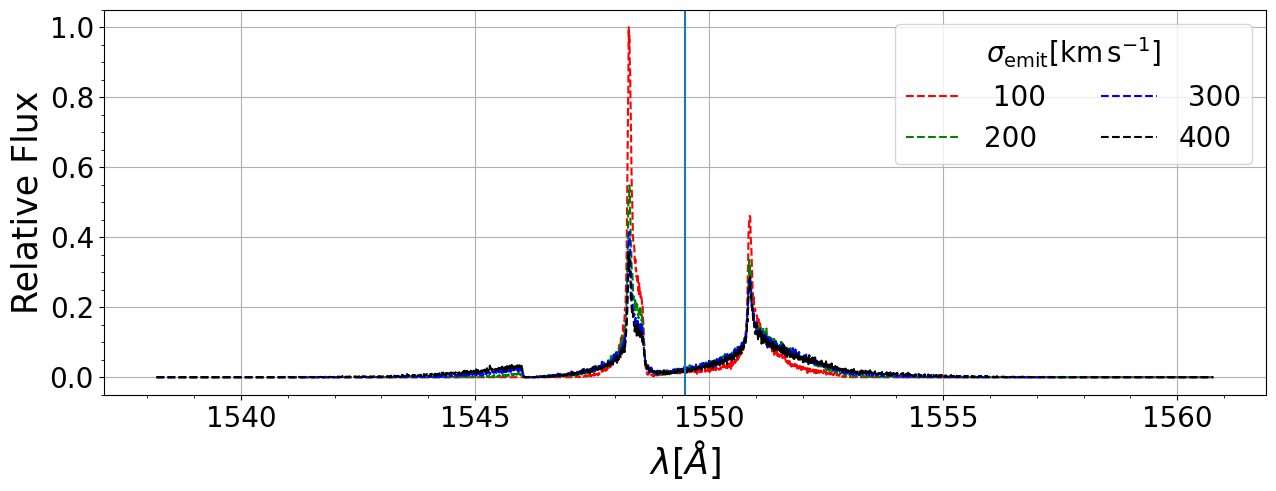

In [31]:
fig = plt.figure(1,figsize=(15,5))
atom_n,index, expand = 50,16,4
emit_n = 100
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'])
plt.plot(globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/normal,'r--',label=f' {emit_n}')
plt.plot(globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{emit_n}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/normal,'r--')

emit_n = 200
plt.plot(globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal ,'g--',label=f'{emit_n}')
plt.plot(globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{emit_n}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'g--')

emit_n = 300
plt.plot(globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'b--',label=f' {emit_n}')
plt.plot(globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'b--')

emit_n = 400
plt.plot(globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'k--',label=f'{emit_n}')
plt.plot(globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'k--')


vv = ((C_IV_H_wo + C_IV_K_wo)/2)
plt.axvline(vv ,ymin=0,ymax=10)
# plt.xlim(-300, 1000)
plt.minorticks_on()
# plt.xlim(-1500,1500)
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=2,title=r'$\sigma_{{\rm emit}} [\rm km \, s^{-1} ]$',title_fontsize=20)
plt.xlabel(r'$\lambda [\AA]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

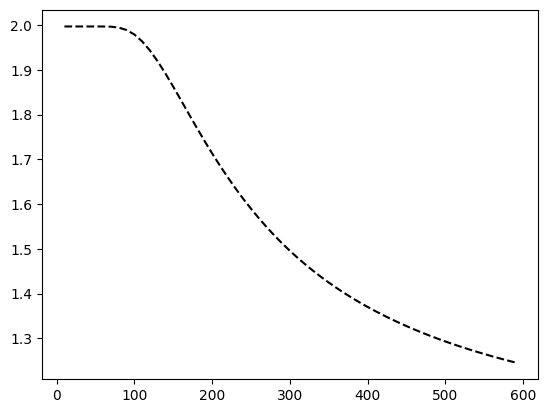

In [32]:
sigma_test = np.arange(10,600,10)
RC = np.zeros(len(sigma_test))

for ii, sig in enumerate(sigma_test):
    RC[ii],globals()[f'analy_fx_{sig}'] = analy_function(sig)

plt.plot(sigma_test,RC,'k--')

In [33]:
def function(sigma,lam,lam_k,lam_h):
    tv_k = ((lam-lam_k) / lam_k ) * cc_k
    tv_h = ((lam-lam_h) / lam_h ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    return fx , f0

NN = 10000
x = np.linspace(1530,1570,NN)
sigma_tt = np.arange(10,610,10)
C_IV_K = 1548.187 # cm
C_IV_H = 1550.772  # cm
R_c_tt = np.zeros(len(sigma_tt)) 
lam_c = (C_IV_H +C_IV_K) / 2
for ii, sig in (enumerate(sigma_tt)):
    ff,f0 = function(sig,x,C_IV_K,C_IV_H)
    xx_k = x[x<=lam_c]
    xx_h = x[x>lam_c]   
    ff_k = ff[x<=lam_c]
    ff_h = ff[x>lam_c] 
    dlam = x[1]-x[0]
    flux_k = np.sum(ff_k*dlam,axis=0)
    flux_h = np.sum(ff_h*dlam,axis=0)
    R_c_tt[ii] = flux_k/ flux_h

Emit velocity에 따른 Ratio 변화

(0.0, 2.05)

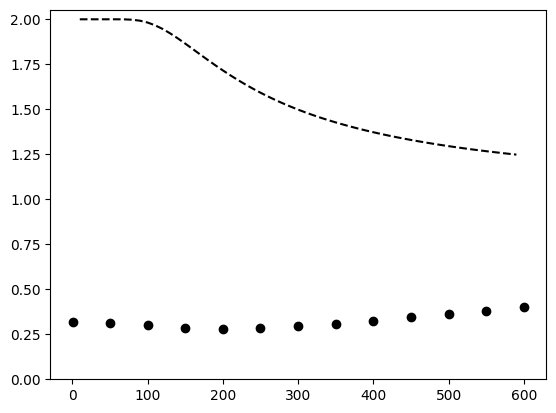

In [57]:
def ratio(x_1,y_1,x_2,y_2):
    delx_1 = x_1[1]- x_1[0]
    total_1 = np.sum(y_1*delx_1,axis=0)
    delx_2 = x_2[1]- x_2[0]
    total_2 = np.sum(y_2*delx_2,axis=0)
    ratio = total_1 / total_2
    return ratio

atom_n,index, expand = 32,15,7

# for jj, expand in
for ii, emit_n in enumerate(em):
    R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
    plt.plot(emit_n,R_C,'ko')
plt.plot(sigma_test,RC,'k--')
plt.ylim(0,2+0.05)


# plt.plot(sigma_tt, R_c_tt,'r-')

1500 1500


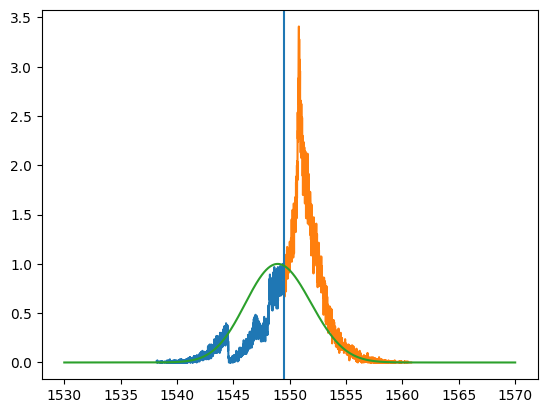

In [61]:
emit_n= 500
NN = 10000  
# expand = 7
xx = np.linspace(1530,1570,NN)
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'])
plt.plot(globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/normal )
plt.plot(globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/normal )
print(len(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']) ,len(globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']) )
plt.axvline(lam_c ,0,1)
plt.plot(xx,globals()[f'analy_fx_{emit_n}'])

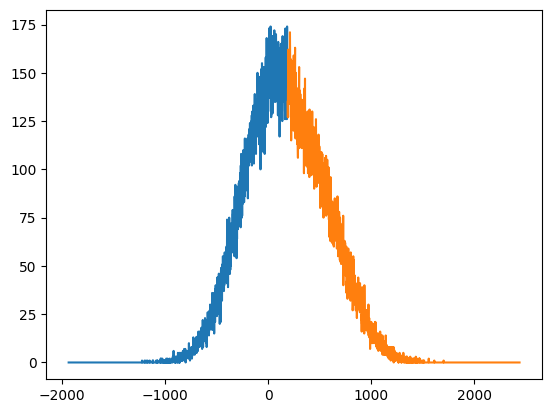

In [ ]:
emit_n =300
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'])
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])